# GUINEA 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy import exp
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.special import factorial
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
from statsmodels.api import Poisson
from scipy import stats
from scipy.stats import norm
from statsmodels.iolib.summary2 import summary_col
import scipy.stats as st
import statsmodels.datasets
import scipy.optimize as optimize
import copy
import scipy.stats as stats
from scipy.integrate import odeint as ode
from scipy.integrate import odeint


## load data

In [2]:
names=["Country","Age group","Gender","Location","Ebola measure","Case definition","Ebola data source","Epi week","Indicator type","Data package ID","Data as of","Outbreak identifier","Display Value","Numeric","Low","High","Comments"]
dtypes={"Country":"str", "Age group":"str", "Gender":"str", "Location":"str","Ebola measure":"str", "Case definition":"str", "Ebola data source": "str", "Epi week": "str","Indicator type": "str",  "Data package ID": "str", "Data as of": "str", "Outbreak identifier": "float","Display Value":"float", "Numeric":"float","Low":"float","High":"float","Comments":"str"} 
data = pd.read_csv("2016-05-11_Guinea.csv",dtype = dtypes,names= names, skiprows=30)

In [3]:
df_tot=pd.DataFrame(data=data)
df=df_tot.drop(columns=['Age group', 'Gender', 'Data as of','Outbreak identifier','Low', 'High', 'Comments'])
#time_steps=np.linspace(0,len(df['Epi week'])/2, len(df['Epi week'])/2, dtype=int)

In [4]:
cities=df['Location'].unique()
cities=cities[0:33]

In [5]:
msk=(df['Ebola data source']=='Patient database') & (df['Case definition']=='Confirmed')

stuff={}
for week in df[msk]['Epi week']:
    stuff[week]=0
    
for week,num in zip(df[msk]['Epi week'],df[msk]['Numeric']):
    stuff[week]=stuff[week]+num

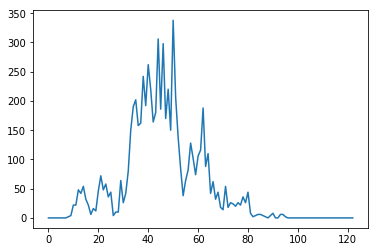

In [6]:
infections = np.ceil(np.array(list(stuff.values())))
plt.plot(infections)
plt.show()

# LINEAR REGRESSION

\begin{equation}\label{eq:}
I(t)= I_{0} e^{(R_{0}-1)(\gamma + \mu)}
\end{equation}


which implies that a semi-log plot of I vs t should be approximately linear with a slope proportional to R0−1 and the recovery rate

In [7]:
from sklearn import linear_model
#linear regression model
reg = linear_model.LinearRegression(fit_intercept=False)
#use log of infection values
time_steps=np.linspace(0,123, 123, dtype=int)
tot_inf=[i+1 if i==0 else i for i in infections]

logI= np.log(tot_inf)
logI= np.nan_to_num(logI)
time_steps= np.nan_to_num(time_steps)
inf_fit= reg.fit(time_steps.reshape(-1,1), logI)
print(inf_fit)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)


A dirty estimation of $R_0 = \frac{slope}{\mu}+1$, we Found $\mu$ in literature to be  0.17825311943

In [8]:
slope=reg.coef_[0]
p_of_inf=0.80142857142 #weeks

In [9]:
R0= (slope*(p_of_inf))+1
print('Basic reproductive number is:',R0)

Basic reproductive number is: 1.0192905497389138


# Models

In [10]:
def SIR_num(beta,mu,lambd,k,S0,X0,R0,T):

    N = S0 + X0 + R0
    
    S = np.empty(7*T+1)
    X = np.empty(7*T+1)
    R = np.empty(7*T+1)
    
    Xcum = np.empty(T)
    
    S[0] = S0
    X[0] = X0
    R[0] = R0
    
    Xcum[0] = 0
    
    for week in range(T):
        Xcum[week] = 0
        for day in range(7):
            t = week*7+day
            bt = beta*np.exp(-k*t)
            S[t+1] = S[t] + lambd*N - lambd*S[t] - bt*S[t]*X[t]/N
            X[t+1] = X[t] - lambd*X[t] + bt*S[t]*X[t]/N -mu*X[t]
            R[t+1] = R[t] - lambd*R[t] +mu*X[t]

            Xcum[week] = Xcum[week] + bt*S[t]*X[t]/N
    
    return S, X, R, Xcum

In [11]:
def SEIR_num(beta,sigma,mu,lambd,k,S0,X0,E0,R0,T):

    N = S0 + E0 + X0 + R0
    
    S = np.empty(7*T+1)
    E = np.empty(7*T+1)
    X = np.empty(7*T+1)
    R = np.empty(7*T+1)
    
    Xcum = np.empty(T)
    
    S[0] = S0
    E[0] = E0
    X[0] = X0
    R[0] = R0
    
    Xcum[0] = 0
    
    for week in range(T):
        Xcum[week] = 0
        for day in range(7):
            t = week*7+day
            bt = beta*np.exp(-k*t)
            S[t+1] = S[t] + lambd*N - lambd*S[t] - bt*S[t]*X[t]/N
            E[t+1] = E[t] - lambd*E[t] + bt*S[t]*X[t]/N -sigma*E[t]
            X[t+1] = X[t] - lambd*X[t] + sigma*E[t] -mu*X[t]
            R[t+1] = R[t] - lambd*R[t] + mu*X[t]

            Xcum[week] = Xcum[week] + bt*S[t]*X[t]/N

    
    return S, E, X, R, Xcum

#  Maximum Likelihood fit

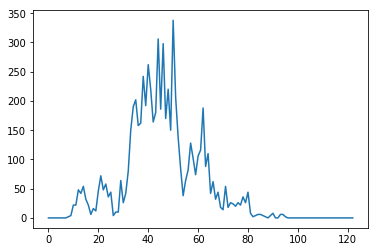

In [12]:
from scipy.stats import poisson
import numpy as np 
import math
import matplotlib.pyplot as plt
data = np.array(infections)
plt.plot(data)
plt.show()

In [13]:
def log_likelihood_cumulative(data,simu,d):
    lk = [k*math.log(lam) -lam -sum([math.log(j+1) for j in range(int(k))]) for k,lam in zip(data,d*simu)]
    return sum(lk)

In [14]:
def log_likelihood_worstcase(data,simu,d):
    lk = [k*math.log(lam) -lam -sum([math.log(j+1) for j in range(int(k))]) for k,lam in zip(data,d*simu)]
    return min(lk)

In [15]:
def get_likelihood_SIR(d,beta,k,dels,data):
    # known initial parameters
    #Exponential decay introduced
    #delay of the epidemic introduced

    S0 = 12000000
    R0 = 0
    X0 = 1
    mu = 0.178
    lambd = 0.0
    
    likelihood = np.empty((len(d),len(beta),len(k)))
    delays = np.empty((len(d),len(beta),len(k)))
    T = len(data)+max(dels)+1

    for i in range(len(beta)):
        for h in range(len(k)):
            #do simulation
            S,X,R,Xcum = SIR_num(beta[i],mu,lambd,k[h],S0,X0,R0,T)

            for j in range(len(d)):
                #get likelihood
                lk = [log_likelihood_cumulative(data,Xcum[int(delay):int(delay)+len(data)],d[j]) for delay in dels]

                likelihood[j,i,h] = max(lk)
                delays[j,i,h] = dels[lk.index(max(lk))]
            
    return likelihood,delays

In [16]:
def get_likelihood_SEIR(d,beta,k,dels,data):
    # initialize known parameters
    #Exponential decay introduced
    #delay of the epidemic introduced
    S0 = 12000000
    E0 = 0
    R0 = 0
    X0 = 1
    sigma = 0.188
    mu = 0.178
    lambd = 0.0
    
    likelihood = np.empty((len(d),len(beta),len(k)))
    delays = np.empty((len(d),len(beta),len(k)))
    
    T = len(data)+max(dels)+1

    for i in range(len(beta)):
        for h in range(len(k)):
            #do simulation
            S,E,X,R,Xcum = SEIR_num(beta[i],sigma,mu,lambd,k[h],S0,E0,X0,R0,T)

            for j in range(len(d)):
                #get likelihood
                lk = [log_likelihood_cumulative(data,Xcum[int(delay):int(delay)+len(data)],d[j]) for delay in dels]
                likelihood[j,i,h] = max(lk)
                delays[j,i,h] = dels[lk.index(max(lk))]
            
    return likelihood,delays

# fit SIR

In [17]:
#create grid for parameters to try
d = np.linspace(0.1,0.5,5)
k = np.linspace(0.0005,0.002,20)
beta = np.linspace(0.20,0.28,20)

print("beta values tried:",beta[0]," .... ", beta[-1])
print("k values tried:",k[0]," ... ", k[-1])
print("d values tried:",d[0]," ... ", d[-1])

beta values tried: 0.2  ....  0.28
k values tried: 0.0005  ...  0.002
d values tried: 0.1  ...  0.5


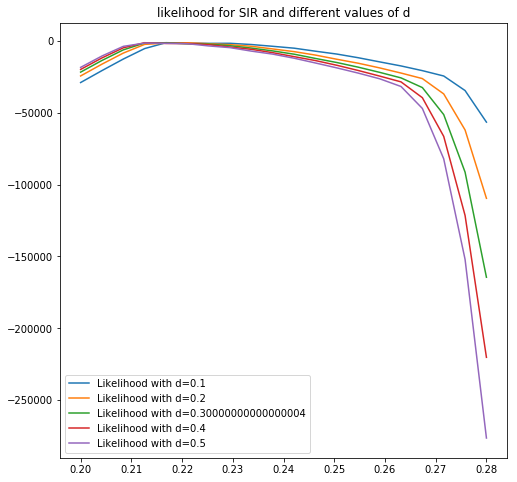

In [18]:
data=[i for i in data if i>0 or i ==0]
dels = [i for i in range(0,10)] #vector of possible delays
likelihood_SIR, delays_SIR = get_likelihood_SIR(d,beta,k,dels,data)

plt.figure(figsize=(8,8))
plt.title("likelihood for SIR and different values of d")
for i in range(len(d)):
    
    plt.plot(beta,np.max(likelihood_SIR[i], axis = 1) , label='Likelihood with d={}'.format(d[i]))
plt.legend()
plt.savefig('Likelihood_function_Guinea_data_with_probailities_d_fitting_SIR_beta_decay.png')
plt.show()

In [19]:
beta_opt_SIR = np.empty(len(d))
k_opt_SIR = np.empty(len(d))
delay_opt_SIR = np.empty(len(d))

for i in range(len(d)):
    ind = np.argmax(likelihood_SIR[i])
    ind = np.unravel_index(ind, likelihood_SIR[i].shape)
    beta_opt_SIR[i] = beta[ind[0]]
    k_opt_SIR[i] = k[ind[1]]
    delay_opt_SIR[i] = delays_SIR[i,ind[0],ind[1]]

# results SIR

optimal beta found:  [0.21684211 0.22105263 0.21684211 0.21263158 0.21263158]
optimal k found:  [0.0005     0.00065789 0.00057895 0.0005     0.0005    ]
optimal delay found:  [9. 0. 2. 4. 4.]


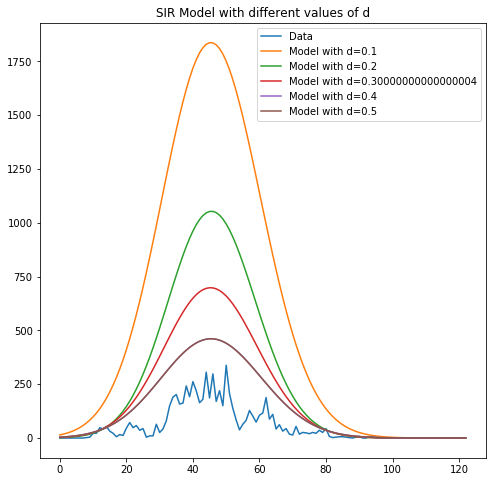

In [20]:
print("optimal beta found: ",beta_opt_SIR)
print("optimal k found: ",k_opt_SIR)
print("optimal delay found: ",delay_opt_SIR)

S0 = 12000000
R0 = 0
X0 = 1
mu = 0.178
lambd = 0.0

T = len(data)+max(dels)+1
plt.figure(figsize=(8,8))
plt.title('SIR Model with different values of d')
plt.plot(data, label='Data')
for i in range(len(d)):
    S,X,R,simu = SIR_num(beta_opt_SIR[i],mu,lambd,k_opt_SIR[i],S0,X0,R0,T)
    plt.plot(simu[int(delay_opt_SIR[i]):int(delay_opt_SIR[i])+len(data)], label='Model with d={}'.format(d[i]))


plt.legend()

plt.savefig('fittingGuineasData_SIR_beta_decay')
plt.show()

# Fit SEIR

In [21]:
# create grid for parameters to try
d = np.linspace(0.1,0.5,5)
k = np.linspace(0.0005,0.005,40)
beta = np.linspace(0.2,0.3,40)

print("beta values tried:",beta[0]," ... ", beta[-1])
print("k values tried:",k[0]," ... ", k[-1])
print("d values tried:",d[0]," ... ", d[-1])

beta values tried: 0.2  ...  0.3
k values tried: 0.0005  ...  0.005
d values tried: 0.1  ...  0.5


likelihood for SIR and different values of d


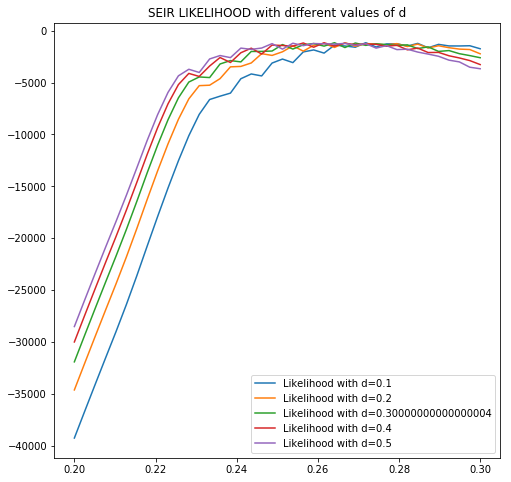

In [22]:
data=[i for i in data if i>0 or i ==0]
dels = [i for i in range(0,10)] #vector of possible delays
likelihood_SEIR, delays_SEIR = get_likelihood_SEIR(d,beta,k,dels,data)

print("likelihood for SIR and different values of d")
plt.figure(figsize=(8,8))
plt.title('SEIR LIKELIHOOD with different values of d')
for i in range(len(d)):
    plt.plot(beta,np.max(likelihood_SEIR[i], axis = 1),label='Likelihood with d={}'.format(d[i]))
plt.legend()
plt.savefig('Likelihood_function_Guinea_data_with_probailities_d_fitting_SEIR_beta_decay.png')
plt.show()

In [23]:
beta_opt_SEIR = np.empty(len(d))
k_opt_SEIR = np.empty(len(d))
delay_opt_SEIR = np.empty(len(d))

for i in range(len(d)):
    ind = np.argmax(likelihood_SEIR[i])
    ind = np.unravel_index(ind, likelihood_SEIR[i].shape)
    beta_opt_SEIR[i] = beta[ind[0]]
    k_opt_SEIR[i] = k[ind[1]]
    delay_opt_SEIR[i] = delays_SEIR[i,ind[0],ind[1]]

# results SEIR

optimal beta found:  [0.27179487 0.26666667 0.26410256 0.26153846 0.25384615]
optimal k found:  [0.00107692 0.00107692 0.00107692 0.00107692 0.00096154]
optimal delay found:  [9. 7. 5. 4. 6.]


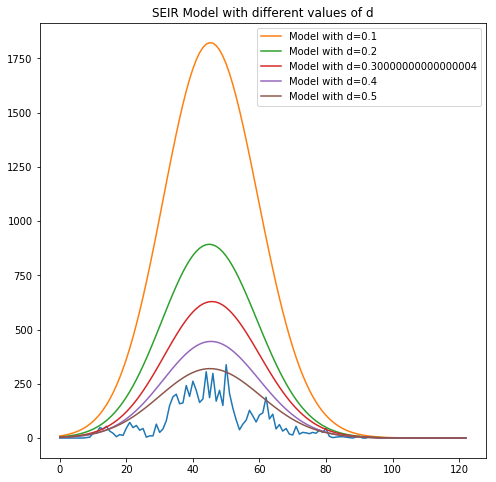

In [24]:
print("optimal beta found: ",beta_opt_SEIR)
print("optimal k found: ",k_opt_SEIR)
print("optimal delay found: ",delay_opt_SEIR)

S0 = 12000000
E0 = 0
R0 = 0
X0 = 1
sigma = 0.188
mu = 0.178
lambd = 0.0

T = len(data)+max(dels)+1

plt.figure(figsize=(8,8))
plt.title('SEIR Model with different values of d')
plt.plot(data)
for i in range(len(d)):
    S,E,X,R,simu = SEIR_num(beta_opt_SEIR[i],sigma,mu,lambd,k_opt_SEIR[i],S0,E0,X0,R0,T)
    plt.plot(simu[int(delay_opt_SEIR[i]):int(delay_opt_SEIR[i])+len(data)], label='Model with d={}'.format(d[i]))



plt.legend()
plt.savefig('fittingGuineasData_SEIR_beta_decay')
plt.show()

# Sierra_Leone

In [25]:
names=["Country","Age group","Gender","Location","Ebola measure","Case definition","Ebola data source","Epi week","Indicator type","Data package ID","Data as of","Outbreak identifier","Display Value","Numeric","Low","High","Comments"]
dtypes={"Country":"str", "Age group":"str", "Gender":"str", "Location":"str","Ebola measure":"str", "Case definition":"str", "Ebola data source": "str", "Epi week": "str","Indicator type": "str",  "Data package ID": "str", "Data as of": "str", "Outbreak identifier": "float","Display Value":"float", "Numeric":"float","Low":"float","High":"float","Comments":"str"} 
dataS = pd.read_csv("2016-05-11_sierra_leone.csv",dtype = dtypes,names= names, skiprows=30)

In [26]:
df_tot=pd.DataFrame(data=dataS)
dfS=df_tot.drop(columns=['Age group', 'Gender', 'Data as of','Outbreak identifier','Low', 'High', 'Comments'])
#time_steps=np.linspace(0,len(df['Epi week'])/2, len(df['Epi week'])/2, dtype=int)

In [27]:
msk=(dfS['Ebola data source']=='Patient database') & (dfS['Case definition']=='Confirmed')

stuffS={}
for week in dfS[msk]['Epi week']:
    stuffS[week]=0
    
for week,num in zip(dfS[msk]['Epi week'],dfS[msk]['Numeric']):
    stuffS[week]=stuffS[week]+num

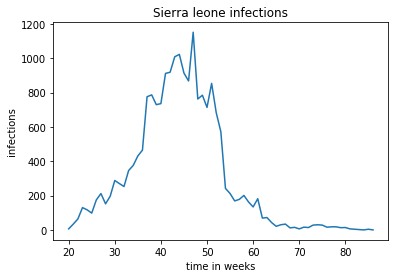

In [28]:
inf_s = np.ceil(np.array(list(stuffS.values())))
plt.title('Sierra leone infections')
plt.xlabel('time in weeks')
plt.plot(inf_s)
plt.ylabel('infections')
plt.show()

In [29]:
def get_likelihood_SIR(d,beta,k,dels,data):
    # known initial parameters
    #Exponential decay introduced
    #delay of the epidemic introduced

    S0 = 7000000
    R0 = 0
    X0 = 1
    mu = 0.178
    lambd = 0.0
    
    likelihood = np.empty((len(d),len(beta),len(k)))
    delays = np.empty((len(d),len(beta),len(k)))
    T = len(data)+max(dels)+1

    for i in range(len(beta)):
        for h in range(len(k)):
            #do simulation
            S,X,R,Xcum = SIR_num(beta[i],mu,lambd,k[h],S0,X0,R0,T)

            for j in range(len(d)):
                #get likelihood
                lk = [log_likelihood_cumulative(data,Xcum[int(delay):int(delay)+len(data)],d[j]) for delay in dels]

                likelihood[j,i,h] = max(lk)
                delays[j,i,h] = dels[lk.index(max(lk))]
            
    return likelihood,delays

In [30]:
def get_likelihood_SEIR(d,beta,k,dels,data):
    # initialize known parameters
    #Exponential decay introduced
    #delay of the epidemic introduced
    S0 = 7000000
    E0 = 0
    R0 = 0
    X0 = 1
    sigma = 0.188
    mu = 0.178
    lambd = 0.0
    
    likelihood = np.empty((len(d),len(beta),len(k)))
    delays = np.empty((len(d),len(beta),len(k)))
    
    T = len(data)+max(dels)+1

    for i in range(len(beta)):
        for h in range(len(k)):
            #do simulation
            S,E,X,R,Xcum = SEIR_num(beta[i],sigma,mu,lambd,k[h],S0,E0,X0,R0,T)

            for j in range(len(d)):
                #get likelihood
                lk = [log_likelihood_cumulative(data,Xcum[int(delay):int(delay)+len(data)],d[j]) for delay in dels]
                likelihood[j,i,h] = max(lk)
                delays[j,i,h] = dels[lk.index(max(lk))]
            
    return likelihood,delays

# SIR fit sierra leone

In [31]:
#create grid for parameters to try
d = np.linspace(0.1,0.9,5)
k = np.linspace(0.0005,0.004,20)
beta = np.linspace(0.2,0.7,20)

print("beta values tried:",beta[0]," .... ", beta[-1])
print("k values tried:",k[0]," ... ", k[-1])
print("d values tried:",d[0]," ... ", d[-1])

beta values tried: 0.2  ....  0.7
k values tried: 0.0005  ...  0.004
d values tried: 0.1  ...  0.9


In [32]:
dataS=[i for i in inf_s if i > 0 or i ==0]
#print(dataS)

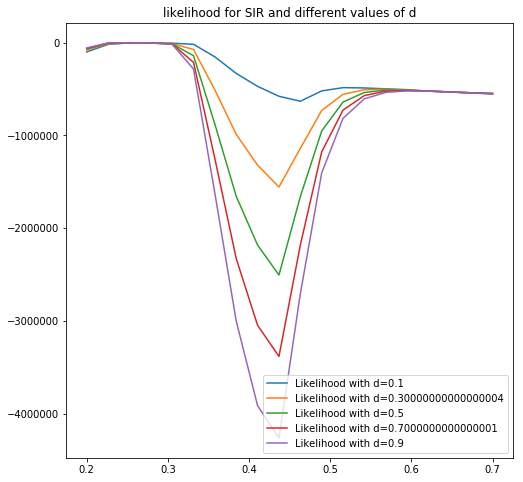

In [33]:
dels = [i for i in range(0,10)] #vector of possible delays
likelihood_SIR, delays_SIR = get_likelihood_SIR(d,beta,k,dels,dataS)

plt.figure(figsize=(8,8))
plt.title("likelihood for SIR and different values of d")
for i in range(len(d)):
    
    plt.plot(beta,np.max(likelihood_SIR[i], axis = 1) , label='Likelihood with d={}'.format(d[i]))

plt.legend()
plt.savefig('Likelihood_function_Sierra_data_with_probailities_d_fitting_SIR_beta_decay.png')

plt.show()

In [34]:
beta_opt_SIR = np.empty(len(d))
k_opt_SIR = np.empty(len(d))
delay_opt_SIR = np.empty(len(d))

for i in range(len(d)):
    ind = np.argmax(likelihood_SIR[i])
    ind = np.unravel_index(ind, likelihood_SIR[i].shape)
    beta_opt_SIR[i] = beta[ind[0]]
    k_opt_SIR[i] = k[ind[1]]
    delay_opt_SIR[i] = delays_SIR[i,ind[0],ind[1]]

# SIR results sierra leone

optimal beta found:  [0.27894737 0.25263158 0.25263158 0.25263158 0.25263158]
optimal k found:  [0.00215789 0.00160526 0.00160526 0.00178947 0.00178947]
optimal delay found:  [4. 6. 6. 3. 3.]


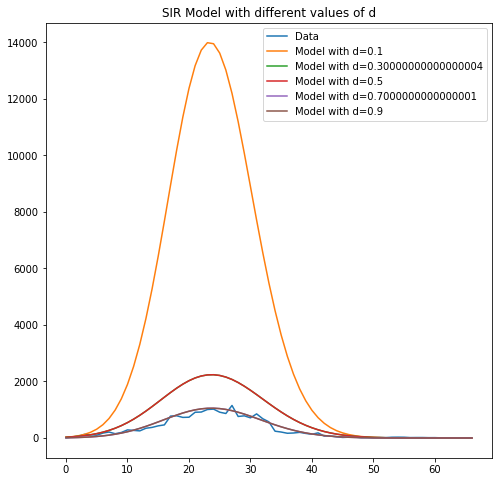

In [35]:
print("optimal beta found: ",beta_opt_SIR)
print("optimal k found: ",k_opt_SIR)
print("optimal delay found: ",delay_opt_SIR)

S0 = 7000000
R0 = 0
X0 = 1
mu = 0.178
lambd = 0.0

T = len(dataS)+max(dels)+1
plt.figure(figsize=(8,8))
plt.title('SIR Model with different values of d')
plt.plot(dataS, label='Data')
for i in range(len(d)):
    S,X,R,simu = SIR_num(beta_opt_SIR[i],mu,lambd,k_opt_SIR[i],S0,X0,R0,T)
    plt.plot(simu[int(delay_opt_SIR[i]):int(delay_opt_SIR[i])+len(dataS)], label='Model with d={}'.format(d[i]))



plt.legend()
plt.savefig('fittingGSierrasData_SIR_beta_decay')
plt.show()

# SEIR fit sierra leone

In [36]:
# create grid for parameters to try
d = np.linspace(0.3,0.5,5)
k = np.linspace(0.0005,0.005,30)
beta = np.linspace(0.2,0.55,30)

print("beta values tried:",beta[0]," ... ", beta[-1])
print("k values tried:",k[0]," ... ", k[-1])
print("d values tried:",d[0]," ... ", d[-1])

beta values tried: 0.2  ...  0.55
k values tried: 0.0005  ...  0.005
d values tried: 0.3  ...  0.5


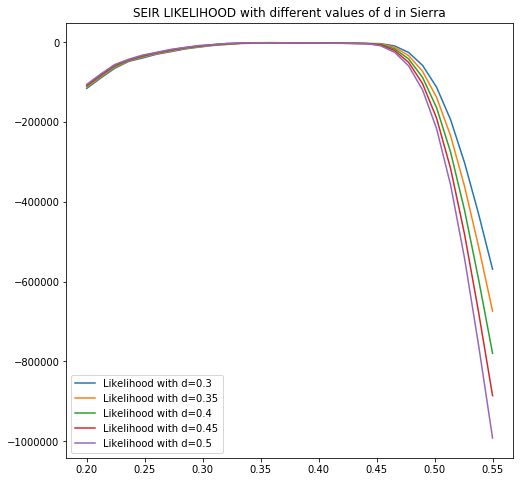

In [37]:
dels = [i for i in range(0,10)] #vector of possible delays
likelihood_SEIR, delays_SEIR = get_likelihood_SEIR(d,beta,k,dels,dataS)

plt.figure(figsize=(8,8))
plt.title('SEIR LIKELIHOOD with different values of d in Sierra')
for i in range(len(d)):
    plt.plot(beta,np.max(likelihood_SEIR[i], axis = 1),label='Likelihood with d={}'.format(d[i]))


plt.legend()
plt.savefig('Likelihood_function_Sierra_data_with_probailities_d_fitting_SEIR_beta_decay.png')
plt.show()

In [38]:
beta_opt_SEIR = np.empty(len(d))
k_opt_SEIR = np.empty(len(d))
delay_opt_SEIR = np.empty(len(d))

for i in range(len(d)):
    ind = np.argmax(likelihood_SEIR[i])
    ind = np.unravel_index(ind, likelihood_SEIR[i].shape)
    beta_opt_SEIR[i] = beta[ind[0]]
    k_opt_SEIR[i] = k[ind[1]]
    delay_opt_SEIR[i] = delays_SEIR[i,ind[0],ind[1]]

# SEIR Results sierra leone

optimal beta found:  [0.35689655 0.36896552 0.34482759 0.35689655 0.35689655]
optimal k found:  [0.00282759 0.00313793 0.00267241 0.00298276 0.00298276]
optimal delay found:  [9. 8. 9. 8. 8.]


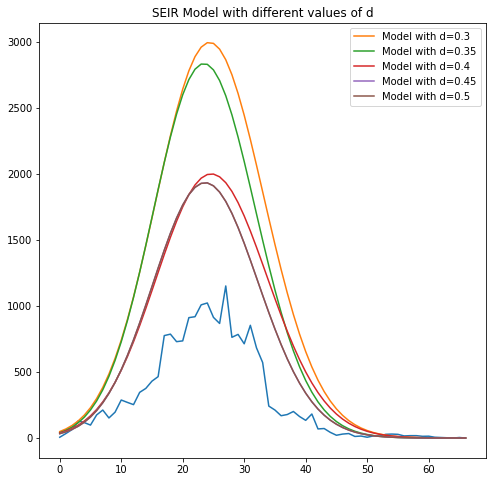

In [39]:
print("optimal beta found: ",beta_opt_SEIR)
print("optimal k found: ",k_opt_SEIR)
print("optimal delay found: ",delay_opt_SEIR)

S0 = 7000000
E0 = 0
R0 = 0
X0 = 1
sigma = 0.188
mu = 0.178
lambd = 0.0

T = len(dataS)+max(dels)+1

plt.figure(figsize=(8,8))
plt.title('SEIR Model with different values of d')
plt.plot(dataS)
for i in range(len(d)):
    S,E,X,R,simu = SEIR_num(beta_opt_SEIR[i],sigma,mu,lambd,k_opt_SEIR[i],S0,E0,X0,R0,T)
    plt.plot(simu[int(delay_opt_SEIR[i]):int(delay_opt_SEIR[i])+len(dataS)], label='Model with d={}'.format(d[i]))


plt.legend()
plt.savefig('fittingSierasData_SEIR_beta_decay')
plt.show()

# Liberia

In [41]:
names=["Country","Age group","Gender","Location","Ebola measure","Case definition","Ebola data source","Epi week","Indicator type","Data package ID","Data as of","Outbreak identifier","Display Value","Numeric","Low","High","Comments"]
dtypes={"Country":"str", "Age group":"str", "Gender":"str", "Location":"str","Ebola measure":"str", "Case definition":"str", "Ebola data source": "str", "Epi week": "str","Indicator type": "str",  "Data package ID": "str", "Data as of": "str", "Outbreak identifier": "float","Display Value":"float", "Numeric":"float","Low":"float","High":"float","Comments":"str"} 
data_lib = pd.read_csv("2016-05-11_Liberia.csv",dtype = dtypes,names= names, skiprows=30)

In [42]:
df_tot=pd.DataFrame(data=data_lib)
df_lib=df_tot.drop(columns=['Age group', 'Gender', 'Data as of','Outbreak identifier','Low', 'High', 'Comments'])
#time_steps=np.linspace(0,len(df['Epi week'])/2, len(df['Epi week'])/2, dtype=int)

In [43]:
msk=(df_lib['Ebola data source']=='Patient database') & (df_lib['Case definition']=='Confirmed')

stuffL={}
for week in df_lib[msk]['Epi week']:
    stuffL[week]=0
    
for week,num in zip(df_lib[msk]['Epi week'],df_lib[msk]['Numeric']):
    stuffL[week]=stuffL[week]+num

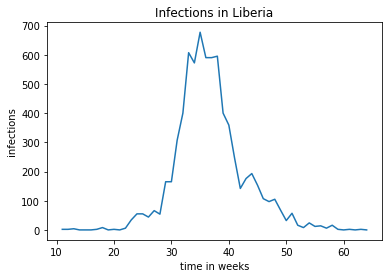

In [44]:
inf_lib = np.ceil(np.array(list(stuffL.values())))
plt.title('Infections in Liberia')
plt.plot(inf_lib)
plt.xlabel('time in weeks')
plt.ylabel('infections')
plt.show()

# SIR FIT 

In [45]:
data_lib= inf_lib

In [46]:
def get_likelihood_SIR(d,beta,k,dels,data):
    # known initial parameters
    #Exponential decay introduced
    #delay of the epidemic introduced

    S0 = 4300000
    R0 = 0
    X0 = 1
    mu = 0.178
    lambd = 0.0
    
    likelihood = np.empty((len(d),len(beta),len(k)))
    delays = np.empty((len(d),len(beta),len(k)))
    T = len(data)+max(dels)+1

    for i in range(len(beta)):
        for h in range(len(k)):
            #do simulation
            S,X,R,Xcum = SIR_num(beta[i],mu,lambd,k[h],S0,X0,R0,T)

            for j in range(len(d)):
                #get likelihood
                lk = [log_likelihood_cumulative(data,Xcum[int(delay):int(delay)+len(data)],d[j]) for delay in dels]

                likelihood[j,i,h] = max(lk)
                delays[j,i,h] = dels[lk.index(max(lk))]
            
    return likelihood,delays

In [47]:
#create grid for parameters to try
d = np.linspace(0.1,0.5,5)
k = np.linspace(0.0005,0.006,40)
beta = np.linspace(0.23,0.32,40)

print("beta values tried:",beta[0]," .... ", beta[-1])
print("k values tried:",k[0]," ... ", k[-1])
print("d values tried:",d[0]," ... ", d[-1])

beta values tried: 0.23  ....  0.32
k values tried: 0.0005  ...  0.006
d values tried: 0.1  ...  0.5


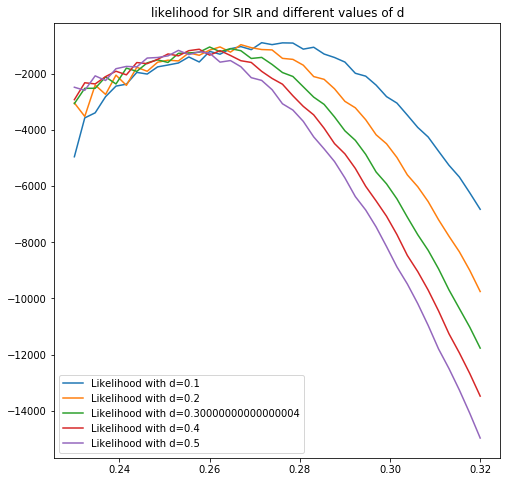

In [48]:
#exclude nan
data_l=[i for i in data_lib if i > 0 or i==0]
dels = [i for i in range(0,10)] #vector of possible delays
likelihood_SIR, delays_SIR = get_likelihood_SIR(d,beta,k,dels,data_l)

plt.figure(figsize=(8,8))
plt.title("likelihood for SIR and different values of d")
for i in range(len(d)):
    
    plt.plot(beta,np.max(likelihood_SIR[i], axis = 1) , label='Likelihood with d={}'.format(d[i]))

plt.legend()
plt.savefig('Likelihood_function_Liberia_data_with_probailities_d_fitting_SIR_beta_decay.png')
plt.show()

In [49]:
beta_opt_SIR = np.empty(len(d))
k_opt_SIR = np.empty(len(d))
delay_opt_SIR = np.empty(len(d))

for i in range(len(d)):
    ind = np.argmax(likelihood_SIR[i])
    ind = np.unravel_index(ind, likelihood_SIR[i].shape)
    beta_opt_SIR[i] = beta[ind[0]]
    k_opt_SIR[i] = k[ind[1]]
    delay_opt_SIR[i] = delays_SIR[i,ind[0],ind[1]]

# Liberia SIR Results

optimal beta found:  [0.27153846 0.26692308 0.26       0.25769231 0.25307692]
optimal k found:  [0.00219231 0.00219231 0.00205128 0.00205128 0.00191026]
optimal delay found:  [0. 0. 0. 0. 0.]


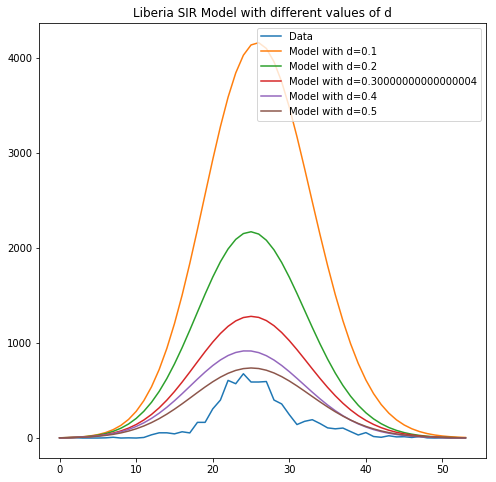

In [50]:
print("optimal beta found: ",beta_opt_SIR)
print("optimal k found: ",k_opt_SIR)
print("optimal delay found: ",delay_opt_SIR)

S0 = 4300000
R0 = 0
X0 = 1
mu = 0.178
lambd = 0.0

T = len(data)+max(dels)+1
plt.figure(figsize=(8,8))
plt.title('Liberia SIR Model with different values of d')
plt.plot(data_l, label='Data')
for i in range(len(d)):
    S,X,R,simu = SIR_num(beta_opt_SIR[i],mu,lambd,k_opt_SIR[i],S0,X0,R0,T)
    plt.plot(simu[int(delay_opt_SIR[i]):int(delay_opt_SIR[i])+len(data_l)], label='Model with d={}'.format(d[i]))


plt.legend()
plt.savefig('fittingLiberiasData_SIR_beta_decay')
plt.show()

# SEIR FIT 

In [51]:
def get_likelihood_SEIR(d,beta,k,dels,data):
    # initialize known parameters
    #Exponential decay introduced
    #delay of the epidemic introduced
    S0 = 4300000
    E0 = 0
    R0 = 0
    X0 = 1
    sigma = 0.188
    mu = 0.178
    lambd = 0.0
    
    likelihood = np.empty((len(d),len(beta),len(k)))
    delays = np.empty((len(d),len(beta),len(k)))
    
    T = len(data)+max(dels)+1

    for i in range(len(beta)):
        for h in range(len(k)):
            #do simulation
            S,E,X,R,Xcum = SEIR_num(beta[i],sigma,mu,lambd,k[h],S0,E0,X0,R0,T)

            for j in range(len(d)):
                #get likelihood
                lk = [log_likelihood_cumulative(data,Xcum[int(delay):int(delay)+len(data)],d[j]) for delay in dels]
                likelihood[j,i,h] = max(lk)
                delays[j,i,h] = dels[lk.index(max(lk))]
            
    return likelihood,delays

In [52]:
# create grid for parameters to try
d = np.linspace(0.3,0.5,5)
k = np.linspace(0.003,0.006,30)
beta = np.linspace(0.25,0.4,30)

print("beta values tried:",beta[0]," ... ", beta[-1])
print("k values tried:",k[0]," ... ", k[-1])
print("d values tried:",d[0]," ... ", d[-1])

beta values tried: 0.25  ...  0.4
k values tried: 0.003  ...  0.006
d values tried: 0.3  ...  0.5


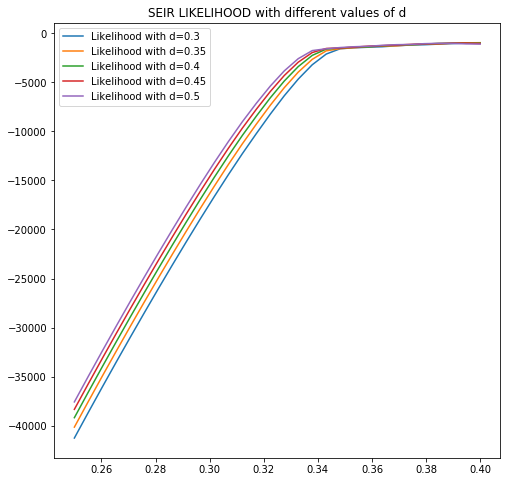

In [53]:
dels = [i for i in range(0,10)] #vector of possible delays
likelihood_SEIR, delays_SEIR = get_likelihood_SEIR(d,beta,k,dels,data_l)

plt.figure(figsize=(8,8))
plt.title('SEIR LIKELIHOOD with different values of d')
for i in range(len(d)):
    plt.plot(beta,np.max(likelihood_SEIR[i], axis = 1),label='Likelihood with d={}'.format(d[i]))


    
plt.legend()
plt.savefig('Likelihood_function_Liberia_data_with_probailities_d_fitting_SEIR_beta_decay.png')
plt.show()

In [54]:
beta_opt_SEIR = np.empty(len(d))
k_opt_SEIR = np.empty(len(d))
delay_opt_SEIR = np.empty(len(d))

for i in range(len(d)):
    ind = np.argmax(likelihood_SEIR[i])
    ind = np.unravel_index(ind, likelihood_SEIR[i].shape)
    beta_opt_SEIR[i] = beta[ind[0]]
    k_opt_SEIR[i] = k[ind[1]]
    delay_opt_SEIR[i] = delays_SEIR[i,ind[0],ind[1]]

# SEIR results Liberia

optimal beta found:  [0.4        0.4        0.4        0.39482759 0.38448276]
optimal k found:  [0.00424138 0.00434483 0.00444828 0.00434483 0.00413793]
optimal delay found:  [0. 0. 0. 0. 0.]


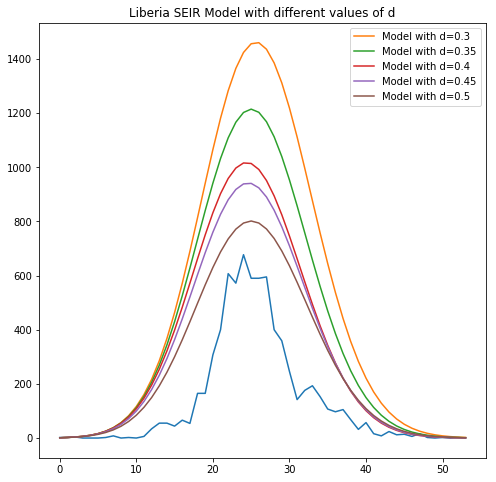

In [55]:
print("optimal beta found: ",beta_opt_SEIR)
print("optimal k found: ",k_opt_SEIR)
print("optimal delay found: ",delay_opt_SEIR)

S0 = 4300000
E0 = 0
R0 = 0
X0 = 1
sigma = 0.188
mu = 0.178
lambd = 0.0

T = len(data_l)+max(dels)+1

plt.figure(figsize=(8,8))
plt.title('Liberia SEIR Model with different values of d')
plt.plot(data_l)
for i in range(len(d)):
    S,E,X,R,simu = SEIR_num(beta_opt_SEIR[i],sigma,mu,lambd,k_opt_SEIR[i],S0,E0,X0,R0,T)
    plt.plot(simu[int(delay_opt_SEIR[i]):int(delay_opt_SEIR[i])+len(data_l)], label='Model with d={}'.format(d[i]))

    
    
plt.legend()
plt.savefig('fittingLiberiasData_SEIR_beta_decay')
plt.show()

In [56]:
x1=np.ceil(np.array(list(stuff.values())))
x2=np.ceil(np.array(list(stuffS.values())))
x3=np.ceil(np.array(list(stuffL.values())))

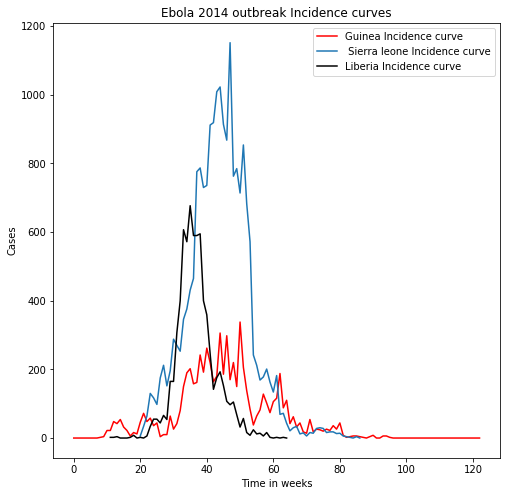

In [57]:
fig= plt.figure(figsize=(8,8))
plt.title('Ebola 2014 outbreak Incidence curves')
plt.plot(x1, label='Guinea Incidence curve', color='red')
plt.plot(x2, label=' Sierra leone Incidence curve')
plt.plot(x3, label='Liberia Incidence curve', color='black')
plt.xlabel('Time in weeks')
plt.ylabel('Cases')
plt.legend()
plt.show()